<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_3_Ultra_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2_%D0%93%D0%B5%D0%BE%D1%80%D0%B3%D0%B8%D1%8F_150x150_0_868_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание св Георгия на изображениях

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adamax, Adadelta, Adagrad
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import random

# хочу время замерить ))
from datetime import datetime

# выводим для примера картинку для каждого класса
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Загрузка данных
---
* Это задание мне прислали из Новосибирска как тест на junior
* Сразу скажу, что данные я загрузил еще 2 недели назад, когда пытался сделать это тестовое задание после первой недели учебы в УИИ. Поэтому просто приведу код, без адаптации к конкретному ноутбуку
* По папкам я уже копировал картинки самостоятельно, а также вручную убирал дубликаты (часто с разными названиями но одинаковые картинки) и не-георгии, бывшие в папке с георгиями

In [ ]:
!pip3 install wget

import wget
import pandas as pd

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=01152600f435e305eeb287ed24b38fa2f4ba563d5b8cca3bc34c550a5d655171
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# Формирование массива со ссылками на Георгиев
georges_url = pd.read_csv('georges.csv', sep=',',header=None)

georges_url.columns = ['URL'] # задал имя столбца
print(georges_url.head(), len(georges_url)) # проверил массив
georges_url = georges_url['URL']

In [ ]:
# Формирование массива со ссылками на НЕ-Георгиев
non_georges_url = pd.read_csv('non_georges.csv', sep=',',header=None)

non_georges_url.columns = ['URL'] # задал имя столбца
print(non_georges_url.head(), len(non_georges_url)) # проверил массив
non_georges_url = non_georges_url['URL']

                                                 URL
0  https://i.pinimg.com/736x/fd/65/bb/fd65bb679b7...
1  https://i.pinimg.com/736x/78/63/a2/7863a2404af...
2  https://i.pinimg.com/736x/bc/3a/f4/bc3af41444c...
3  https://i.pinimg.com/736x/46/a3/59/46a3595eec7...
4  https://i.pinimg.com/736x/54/b2/ef/54b2ef7af71... 3366


In [ ]:
# загрузим в массив всех Георгиев и НЕ-Гергиев на диск

start_time = datetime.now()

for i in range(len(georges_url)):
    load_img(wget.download(georges_url[i], out='georges'))

for i in range(len(non_georges_url)):
    load_img(wget.download(non_georges_url[i], out='non_georges'))

print(datetime.now() - start_time)

0:44:42.092540


In [ ]:
# Загружаю в массивы списки файлов
import os
#import os, fnmatch

listOfFiles_georges = os.listdir('georges')
listOfFiles_nongeorges = os.listdir('non_georges')
print(len(listOfFiles_georges) , len(listOfFiles_nongeorges))

2629 3367


In [ ]:
# Удалил системный файл mac

for i in range(len(listOfFiles_georges) - 1):
    if listOfFiles_georges[i] == '.DS_Store': del listOfFiles_georges[i]
        
for i in range(len(listOfFiles_nongeorges) - 1):
    if listOfFiles_nongeorges[i] == '.DS_Store': del listOfFiles_nongeorges[i]

### Создал нейросеть
-----
* Провел эксперименты с размером изображений. Загружал от 32х32 дл 160х160.7 с последним размером эксперимент продолжается- внезапно сильно замедлилось обучение сетей, хотя я на платном тарифе. Но уже сейчас понятно, что чем лучше качество распознавания, тем более сложную сеть можно построить и тем выше качество обучения. так, например на 32зх32 я не смог добиться СТАБИЛЬНОГО качества больше 84%. А вот с разерами больше 120х120 уже не ждал меньше 84%
* Про подбор гиперпараметров  и усложнения архитектуры писать не буду - уже просто
* Столкнулся с "пилой" в val_accuracy. Отчасти справилься помог перехаод на Nadam, обучение стало ровнее, но дольше
* Была идея вместо accuracy подбирать mae или mape. Но не хватило времени разобраться, как помом, после генератора вывести циклом поочередно все изображения тестовой выборки и сделать предикт.. чтобы посчитать число ошибок.. буду признателен, если включите это в разбор!

In [ ]:
train_dir = 'train' # Каталог с данными для обучения
val_dir = 'val' # Каталог с данными для проверки
test_dir = 'test' # Каталог с данными для тестирования

# Размерность тензора на основе изображения для входных данных в нейронную сеть
img_width, img_height = 150, 150 # Размеры изображения - ПОЭКСПЕРИМЕНИРОВАТЬ!!
#img_width, img_height = 120, 120 # Размеры изображения - ПОЭКСПЕРИМЕНИРОВАТЬ!!
# размер изображения сильно влияет на скорость и еще нужо понять как на качество

#очень важная вещь!!:
input_shape = (img_width, img_height, 3) # backend Tensorflow, channels_last

nb_train_samples = 3897     # Количество изображений для обучения
nb_validation_samples = 687 # Количество изображений для проверки
nb_test_samples = 782       # Количество изображений для тестирования

In [ ]:
N_lr = 0.0001 # Стандарт = 0,0001
epochs = 50
batch_size = 16
kernel_size = 3
pool_size = 2
conv_depth = 32
dense_size = 64*4
k_Dropout = 0.1
num_classes = 2

In [ ]:
# Моя простая сеть побыстрее проверить
model = Sequential()
  
model.add(BatchNormalization(input_shape=input_shape)) #Слой пакетной нормализации (ВНИМАТЕЛЬНО С input_shape - он не такой,как в нашем примере из)
model.add(Conv2D(conv_depth, (kernel_size, kernel_size), padding='same', activation='relu')) #Первый сверточный слой
model.add(Conv2D(conv_depth, (kernel_size, kernel_size), padding='same', activation='relu')) #Первый сверточный слой
model.add(Conv2D(conv_depth, (kernel_size, kernel_size), padding='same', activation='relu')) #Первый сверточный слой
model.add(Conv2D(conv_depth, (kernel_size, kernel_size), padding='same', activation='relu')) #Первый сверточный слой
model.add(Conv2D(conv_depth, (kernel_size, kernel_size), padding='same', activation='relu')) #Первый сверточный слой
model.add(MaxPooling2D(pool_size=(pool_size, pool_size))) #Первый слой подвыборки
#model.add(Dropout(k_Dropout)) #Слой регуляризации Dropout

model.add(BatchNormalization()) #Слой пакетной нормализации
model.add(Conv2D(conv_depth*2, (kernel_size, kernel_size), padding='same', activation='relu')) #Третий сверточный слой
model.add(Conv2D(conv_depth*2, (kernel_size, kernel_size), padding='same', activation='relu')) #Третий сверточный слой
model.add(Conv2D(conv_depth*2, (kernel_size, kernel_size), padding='same', activation='relu')) #Третий сверточный слой
model.add(Conv2D(conv_depth*2, (kernel_size, kernel_size), padding='same', activation='relu')) #Третий сверточный слой
model.add(Conv2D(conv_depth*2, (kernel_size, kernel_size), padding='same', activation='relu')) #Третий сверточный слой
model.add(MaxPooling2D(pool_size=(pool_size, pool_size))) #Второй слой подвыборки
#model.add(Dropout(k_Dropout)) #Слой регуляризации Dropout

model.add(BatchNormalization()) #Слой пакетной нормализации
model.add(Conv2D(conv_depth*4, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*4, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*4, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*4, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*4, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(MaxPooling2D(pool_size=(pool_size, pool_size))) #Третий слой подвыборки
#model.add(Dropout(k_Dropout)) #Слой регуляризации Dropout

model.add(BatchNormalization()) #Слой пакетной нормализации
model.add(Conv2D(conv_depth*6, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*6, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*6, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*6, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(Conv2D(conv_depth*6, (kernel_size, kernel_size), padding='same', activation='relu')) #Пятый сверточный слой
model.add(MaxPooling2D(pool_size=(pool_size, pool_size))) #Третий слой подвыборки
#model.add(Dropout(k_Dropout)) #Слой регуляризации Dropout

model.add(Flatten()) #Слой преобразования данных из 2D представления в плоское
model.add(Dense(dense_size, activation='relu')) #Полносвязный слой для классификации
#model.add(Dropout(k_Dropout*2))
model.add(Dense((1), activation='sigmoid')) #Выходной полносвязный слой softmax???


model.compile(loss='binary_crossentropy',
              optimizer=Nadam(N_lr), 
              metrics=['accuracy'])

### Настроил генераторы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples')

In [ ]:
# Генератор изображений создается на основе класса ImageDataGenerator.
# ЧЕРЕЗЧУР СЛОЖНЫЙ ГЕНЕРАТОР  МОЖЕТ СВОДИТЬ ОБУЧЕНИЕ К НУЛЮ

datagen = ImageDataGenerator(
    rescale=1. / 255,       #Значения цвета меняем на дробные показания
#    rotation_range=10,      #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1,  #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1,         #Зумируем изображения при генерации выборки
    horizontal_flip=True,   #Отключаем отзеркаливание изображений
    fill_mode='constant',       #Заполнение пикселей вне границ ввода
)


In [ ]:
#Генератор данных для обучения на основе изображений из каталога

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3897 images belonging to 2 classes.


In [ ]:
#Генератор данных для проверки на основе изображений из каталога

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 687 images belonging to 2 classes.


In [ ]:
#Генератор данных для тестирования на основе изображений из каталога

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 782 images belonging to 2 classes.


### Обучил модель с использованием генераторов
---
Хорошей идеей оказаласть настройка автоматического замедления обучения модели после того, как последовательно в 2х эпохах val_accuracy не улучшается.
Сильно экономит время!

Epoch 1/50
243/243 [==============================] - 73s 299ms/step - loss: 0.6058 - accuracy: 0.6872 - val_loss: 0.6745 - val_accuracy: 0.6176
Epoch 2/50
243/243 [==============================] - 72s 298ms/step - loss: 0.5507 - accuracy: 0.7325 - val_loss: 0.7457 - val_accuracy: 0.6190
Epoch 3/50
243/243 [==============================] - 72s 298ms/step - loss: 0.5263 - accuracy: 0.7485 - val_loss: 0.5253 - val_accuracy: 0.7277
Epoch 4/50
243/243 [==============================] - 73s 299ms/step - loss: 0.5053 - accuracy: 0.7627 - val_loss: 0.4940 - val_accuracy: 0.7351
Epoch 5/50
243/243 [==============================] - 72s 298ms/step - loss: 0.4936 - accuracy: 0.7617 - val_loss: 0.4500 - val_accuracy: 0.7917
Epoch 6/50
243/243 [==============================] - 72s 297ms/step - loss: 0.4644 - accuracy: 0.7838 - val_loss: 0.5829 - val_accuracy: 0.7336
Epoch 7/50
243/243 [==============================] - 73s 300ms/step - loss: 0.4551 - accuracy: 0.7921 - val_loss: 0.4535 - val_ac

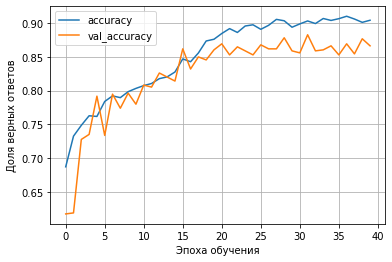

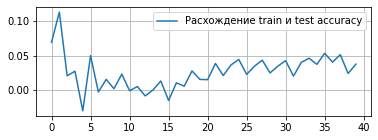

In [ ]:
# хочу время замерить ))
start_time = datetime.now()

# задание условий 
# остановки обучения
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               patience = 8, verbose = 1,
                               restore_best_weights = True)
# замедление скорости
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.5, 
                              verbose = 1,
                              patience = 2, min_lr = 0.0000001)


#train_generator - генератор данных для обучения
#validation_data - генератор данных для проверки
history = model.fit_generator(train_generator,
                              steps_per_epoch=int(nb_train_samples / batch_size),
                              epochs = epochs,
                              verbose = 1,
                              validation_data = val_generator,
                              validation_steps = int(nb_validation_samples / batch_size),
                              callbacks = ([reduce_lr],[early_stopping])
                              )

#сохранение модели
model.save('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples/Georges150x150.h5')
model.save_weights('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples/Georges150x150.hdf5')


print('Время обучения: ', datetime.now() - start_time)

#Отображаем график точности обучения
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],
             label='accuracy')
plt.plot(history.history['val_accuracy'], 
             label='val_accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid()
plt.show()

#считаю отклонение  val_accuracy от accuracy для оценки качества модели
a = np.asarray(history.history['accuracy'])
va = np.asarray(history.history['val_accuracy'])
v = a- va
plt.figure(figsize=(6,2))
plt.plot(v,label='Расхождение train и test accuracy')
plt.legend()
plt.grid()


plt.show()

#инфрмация о структуре модели
#model.summary()

### Оцениваю качество работы сети на тетовой выборке с помощью генератора

In [ ]:
# хочу время замерить ))
start_time = datetime.now()

#Качество предсказания на тестовой выборке
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: ", scores[1])

print('Время обучения: ', datetime.now() - start_time)

Аккуратность на тестовых данных:  0.8684895634651184
Время обучения:  0:00:12.139582


In [ ]:
#сохранение модели
#model.save('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples/Georges_0.868.h5')
#model.save_weights('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples/Georges_0.868.hdf5')


### Не смог решить вопросы:
1. Как вывести картинку и предсказание?
2. Как записать в файл результаты теста? 
получилось создать массив,но дальше ошибка : ValueError: Index data must be 1-dimensional - и никак не могу понять, как исправить ((
3. Ну и конечно надо бы посмотреть, какие там признаки составила сеть на выходе каждого промежуточного слоя.. но реально не хватает времени - сижу сутками до часу ночи )) очень уж интересно

In [ ]:
# и запишем результаты теста в файл:
import pandas as pd

filenames = test_generator.filenames
filenames = np.array(filenames)
predictions = model.predict(test_generator)
print(len(filenames), type(filenames), len(predictions), type(predictions))
predictions.shape

#Вариант 1 не работет ((
arr_res = {'Predictions': predictions, 'Filenames': filenames}
resalts_ = pd.DataFrame(data = arr_res)

#вариант 2 тоже не работает ((
resalts = pd.DataFrame(filenames, predictions, columns=['Filename', 'Predictions'])
results.to_csv("/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_3_Сверточные нейронные сети/data/samples/results.csv",index=True)

782 <class 'numpy.ndarray'> 782 <class 'numpy.ndarray'>


ValueError: ignored